In [137]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor,Compose,RandomHorizontalFlip, Normalize, ToPILImage, RandomRotation, ColorJitter
from torchvision.utils import make_grid
import mcbe


In [138]:
def relu_inv(output, W, b):
    """
    reconstructs x from z = ReLU(Wx - b) using a facet-specific left-inverse 
    setting mode to something else will use the whole active sub-frame
    """
    I = np.where(output > 0)[0] # active frame elements
    W_f = W[I,:]
    b_f = b[I]
    output_f = output[I]
    x = np.linalg.lstsq(W_f,  output_f + b_f, rcond=None)[0] # equivalent to synthesis with the canonical dual frame
    return x

In [139]:
model_cifar = torch.load('models_reconstruction/Final_Model_inj1_trained_further.pt')

In [140]:
weights = model_cifar["fc2.weight"]
bias = model_cifar["fc2.bias"]

In [141]:
def extract(filename):
    with open(filename,"rb") as f:
        batch_data = pickle.load(f,encoding="bytes")
    return batch_data

data = [] #Store all batches in a list
for files in os.listdir("cifar-10-batches-py"):
    if "_batch" in files:
        data.append(extract(os.path.join('./cifar-10-batches-py',files)))

class CIFAR10(Dataset):
    
    def __init__(self,root,train=True,transforms=None):
        self.root = root
        self.transforms = transforms
        self.split = train
        
        self.data = []
        self.targets = []
        self.train_data = [file for file in os.listdir(root) if "data_batch" in file]
        self.test_data = [file for file in os.listdir(root) if "test_batch" in file]
                
        data_split = self.train_data if self.split else self.test_data
        
        for files in data_split:
            entry = self.extract(os.path.join(root,files))
            self.data.append(entry["data"])
            self.targets.extend(entry["labels"])
                
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))
        self.load_meta()
        
    def extract(self,filename):
        with open(filename,"rb") as f:
            batch_data = pickle.load(f,encoding="latin1")
        return batch_data  
    
    def load_meta(self):
        path = os.path.join(self.root,"batches.meta")
        with open(path,"rb") as infile:
            data = pickle.load(infile,encoding="latin1")
            self.classes = data["label_names"]
            self.classes_to_idx = {_class:i for i,_class in enumerate(self.classes)}
            
    def plot(self,image,target=None):
        if target is not None:
            print(f"Target :{target} class :{self.classes[target]}")
        plt.figure(figsize=(2,2))
        plt.imshow(image.permute(1,2,0))
        plt.show()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image,target = self.data[idx],self.targets[idx]
        image = Image.fromarray(image)
        
        if self.transforms:
            image = self.transforms(image)
            
        return image,target
    
train_set = CIFAR10(root="./cifar-10-batches-py",train=True,
                    transforms=Compose([
                        ToTensor()]))
test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                    transforms=Compose([
                        ToTensor()]))

In [142]:
test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                    transforms=Compose([
                            ToTensor(),
                            Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                    std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                        ]))

In [143]:
test_set.__getitem__(2)


(tensor([[[ 0.5190,  0.5190,  0.2174,  ...,  1.6302,  1.7731,  1.7890],
          [ 0.7095,  0.7412,  0.4079,  ...,  1.6937,  1.9160,  1.9160],
          [ 0.7730,  0.8047,  0.5031,  ...,  1.6620,  1.9795,  1.9001],
          ...,
          [-1.4971, -1.5130, -1.5765,  ..., -1.4018, -1.8463, -1.9257],
          [-1.6241, -1.5606, -1.5923,  ..., -1.6876, -1.9257, -1.9098],
          [-1.5447, -1.5130, -1.4812,  ..., -1.9098, -1.9257, -1.8781]],
 
         [[ 1.0799,  1.0316,  0.6934,  ...,  1.7402,  1.8691,  1.9013],
          [ 1.2410,  1.2249,  0.8544,  ...,  1.7564,  1.9818,  1.9979],
          [ 1.2571,  1.2410,  0.9027,  ...,  1.7080,  2.0302,  1.9496],
          ...,
          [-1.3360, -1.3521, -1.4165,  ..., -1.3360, -1.7709, -1.8675],
          [-1.4326, -1.3682, -1.4004,  ..., -1.6581, -1.8836, -1.8675],
          [-1.3199, -1.2877, -1.2555,  ..., -1.8836, -1.8997, -1.8514]],
 
         [[ 1.6211,  1.5611,  1.2013,  ...,  1.8010,  1.9359,  1.9809],
          [ 1.7260,  1.6811,

In [144]:
class ConvNet_return_mcbe(nn.Module):

    def __init__(self):
        super(ConvNet_return_mcbe,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,stride=1,kernel_size=(3,3),padding=1)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=(3,3),padding=1,stride=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding=1,stride=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=1,stride=1)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1)

        self.fc1 = nn.Linear(in_features=6*6*256,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=512)
        self.fc3 = nn.Linear(in_features=512,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=64)
        self.fc5 = nn.Linear(in_features=64,out_features=10)
        
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.dropout = nn.Dropout2d(p=0.5)
        
    def return_mcbe_input(self,x,targets,inj=True):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1,6*6*256)
        x = F.relu(self.fc1(x))
        mcbe_train = x.detach().numpy()
        return mcbe_train
    
    def return_mcbe_output(self,x,targets,inj=True):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1,6*6*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x.detach().numpy()

In [145]:
return_mcbe = ConvNet_return_mcbe()

In [146]:
return_mcbe.load_state_dict(torch.load("models_reconstruction/Final_Model_inj2.pt"))

<All keys matched successfully>

In [147]:
input = return_mcbe.return_mcbe_input(test_set.__getitem__(2)[0],test_set.__getitem__(2)[1])
output = return_mcbe.return_mcbe_output(test_set.__getitem__(2)[0],test_set.__getitem__(2)[1])

In [148]:
input.shape

(1, 256)

In [149]:
output.shape

(1, 512)

In [150]:
reconstructed_output = relu_inv(np.array(output)[0], np.array(weights), np.array(bias))

In [151]:
np.linalg.norm(reconstructed_output - np.array(input)[0])

74.55567

In [152]:
errors = []
for i in range(100):
    input = return_mcbe.return_mcbe_input(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1])
    output = return_mcbe.return_mcbe_output(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1])
    reconstructed_output = relu_inv(np.array(output)[0], np.array(weights), np.array(bias))
    errors.append(np.linalg.norm(reconstructed_output - np.array(input)[0]))

In [158]:
np.array([return_mcbe.return_mcbe_input(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1]) for i in range(100)])

c:\Users\heckert\AppData\Local\anaconda3_new\envs\pbe\Lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


array([[[0.       , 0.       , 0.9408152, ..., 0.       , 0.       ,
         0.       ]],

       [[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]],

       [[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]],

       ...,

       [[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]],

       [[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]],

       [[0.       , 0.       , 2.9220035, ..., 0.       , 0.       ,
         0.       ]]], dtype=float32)

In [169]:
percent_inj = []
for i in range(100):
    percent_inj.append(mcbe.check_injectivity_naive(np.array(weights), np.array(bias), iter =1, points=np.array(return_mcbe.return_mcbe_input(train_set.__getitem__(i)[0],train_set.__getitem__(i)[1]))))


c:\Users\heckert\AppData\Local\anaconda3_new\envs\pbe\Lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [171]:
np.mean(percent_inj)

0.0

In [177]:
np.array([np.array(return_mcbe.return_mcbe_input(train_set.__getitem__(i)[0],train_set.__getitem__(i)[1])).flatten() for i in range(100)])

c:\Users\heckert\AppData\Local\anaconda3_new\envs\pbe\Lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


array([[ 0.      ,  0.      , 16.93454 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 11.039252, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 10.419275, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [313]:
X_train = np.array([np.array(return_mcbe.return_mcbe_input(train_set.__getitem__(i)[0],train_set.__getitem__(i)[1])).flatten() for i in range(100)])
X_test = np.array([np.array(return_mcbe.return_mcbe_input(test_set.__getitem__(i)[0],test_set.__getitem__(i)[1])).flatten() for i in range(100)])
weights = model_cifar["fc2.weight"]
weights = np.array(weights)

c:\Users\heckert\AppData\Local\anaconda3_new\envs\pbe\Lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [292]:
X_train.shape

(100, 256)

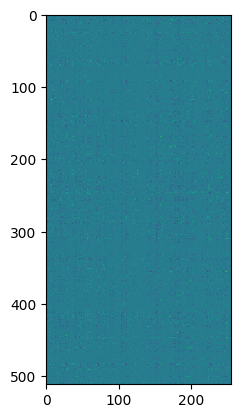

In [320]:
plt.imshow(weights)

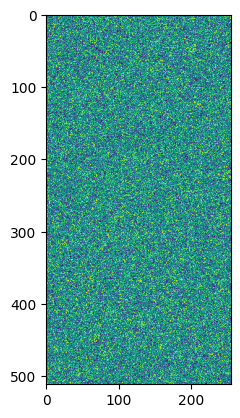

In [318]:
plt.imshow(np.random.random((512,256)))

In [287]:
#X_train = np.random.random((100,256))
#weights = np.random.random((512,256))

In [314]:
max_bias = mcbe.dd_mcbe(W=weights,X_train = X_train, num_estimation_points=100,dd_method="blowup")

In [315]:
percent_inj = []
mcbe.check_injectivity_naive(np.array(weights), np.array(max_bias), iter =100, points=X_train)


0.0

{'whiskers': [<matplotlib.lines.Line2D at 0x217d5d0e8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x217d5d0d950>,
 'boxes': [<matplotlib.lines.Line2D at 0x217d5d0fbd0>],
 'medians': [<matplotlib.lines.Line2D at 0x217d5bff190>],
 'fliers': [<matplotlib.lines.Line2D at 0x217d5c24f90>],
 'means': []}

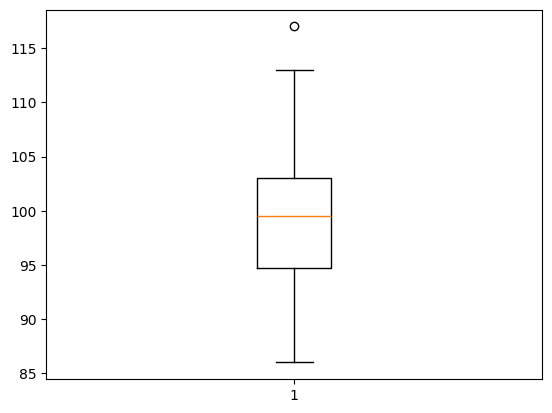

In [333]:
plt.boxplot([np.sum(mcbe.relu(x=X_train[i],W=weights,b=max_bias) > 0) for i in range(100)])

In [328]:
weights.shape

(512, 256)